In [1]:
#| hide
#| default_exp core
from nbdev import *

# Core

> The core functionality of the HECSS module is provided by the `HECSS` class which encapsulates the `Sample` function. The other functions in this module: `normalize_conf` and `write_dfset` are just utilities which are useful in typical use cases.

## `HECSS` class

Standard interface to the HECSS library. This class encapsulates the actual sampler implemented in the `sample` method and provides main functionality of the library through the `generate` method.

In [2]:
#| exporti
import sys
from fastcore.basics import patch

import numpy as np
from numpy import log, exp, sqrt, linspace, dot
import scipy
from scipy import stats
from scipy.special import expit

from tqdm.auto import tqdm
from itertools import islice
from collections import Counter
from matplotlib import pyplot as plt

import ase
import ase.units as un
from ase.calculators import calculator
from ase.data import chemical_symbols
import spglib
from spglib import find_primitive, get_symmetry_dataset

In [3]:
#| export
class HECSS:
    '''
    Class encapsulating the sampling and weight generation 
    for the HECSS algorithm.
    '''
    def __init__(self, cryst, calc, width=1, maxburn=20, 
                 delta_sample=0.01, sigma=2,
                 eqdelta=0.05, eqsigma=0.2,
                 xi=1, chi=1, 
                 w_search=True,
                 xscale_init=None,
                 Ep0=None, modify=None, modify_args=None,
                 directory=None, reuse_base=None, verb=True, 
                 pbar=True, width_list=None, 
                 dofmu_list=None, xscale_list=None, monitor=None):
        self.cryst = cryst
        self.calc = calc
        self.width = width
        self.maxburn = maxburn
        self.wsearch = w_search
        self.pbar = None
        
    def smpl_print(self):
        return
        max_r = 15
        if pbar:
            if i==0:
                pbar.set_postfix(Sample='burn-in', n=k, w=w,
                                 dE=f'{(e_star-E_goal)/Es:+6.2f} sigma', 
                                 xs=f'{sqrt(xscale.std()):6.3f}')
            else :
                pbar.set_postfix(xs=f'{sqrt(xscale.std()):6.3f}', config=f'{i:04d}', 
                                 w=w, w_bar=f'{np.mean([_[0] for _ in wl]) if wl else w:7.3f}')
        elif pbar is None :
            if i==0:
                print(f'Burn-in sample {sqrt(xscale.std()):6.3f}:{k}'
                      f'  w:{w:.4f}'
                      f'  dE:{(e_star-E_goal)/Es:+6.2f} sigma', end='\n')
            else :
                print(f'Sample {sqrt(xscale.std()):6.3f}:{n:04d}'
                      f'w:{w:.4f}  <w>:{np.mean([_[0] for _ in wl]) if wl else w:.4f}', end='\n')
            sys.stdout.flush()
        else :
            pass

        
    def print_xs(self, c, s):
        return
        elmap = c.get_atomic_numbers()
        for el in sorted(set(elmap)):
            print(f'{chemical_symbols[el]:2}: {s[elmap==el,:].mean():8.4f}', end='  ')
        print()
        
    

In [4]:
#| export
@patch
def sample(self: HECSS, T_goal, N=None, 
           w_search=True, delta_sample=0.01, sigma=2,
           eqdelta=0.05, eqsigma=0.2,
           xi=1, chi=1, xscale_init=None,
           logistic_dist = True,
           Ep0=None, modify=None, modify_args=None, symprec=1e-5,
           directory=None, reuse_base=None, verb=True, pbar=False,
           width_list=None, dofmu_list=None, xscale_list=None):
    '''
    Run HECS sampler on the system `cryst` using calculator `calc` at target
    temperature `T_goal`. The `delta`, `width`, `maxburn` and `directory` 
    parameters determine detailed aspects of the algorithm.

    This is a generator and cannot be used as regular function. 
    It is intended to be used as a source of the sequence of 
    configurations in the `for` loop and must be closed after 
    finishing the iteration. On the other hand, the iteration 
    may be continued if additional samples are required. 
    The state is preserved until the .close() method is called.
    
    INPUT
    -----
    T_goal       : Target temperature in Kelvin
    width        : initial width of the position distribution, relative 
                   to the heurestic value defined inside function                  
    maxburn      : max number of burn-in steps
    N            : Number of iterations. If None (default) the generator never stops.
    w_search     : Run search for initial w. If false start from whatever 
                   is passed as width.
    delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    sigma        : Range around E0 in sigmas to stop w-serach mode
    eqdelta      : Max. speed of amplitude correction from step to step (0.05=5%)
    eqsigma      : Half width of linear part of amplitude correction function.
    xi           : strength of the amplitude correction term [0-1]
    chi          : strength of the amplitude correction term mixing [0-1]
    xscale_init  : Initial values of the amplitude correction coefficients.
                   Array with shape `cryst.get_positions().shape`.
                   May be generated with `calc_init_xscale` function.
    Ep0          : T=0 energy (base, no dstortions), if None (default) calculate E0.
    modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    modify_args  : dictionary of extra arguments to pass to modify function
    symprec      : symmetry detection treshold for spglib functions
    directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    verb         : print verbose progress messages for interactive use
    pbar         : tqdm progress bar object. If False (default) there will be no output.
                   If set to None the display will be printed to stdout.
    
    **Output parameters**
    
    width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    dofmu_list   : Output parameter. If not None, store in passed list the array of DOF virials
                   relative to temperature (T_goal).
    xscale_list  : Output parameter. If not None, store in passed list the array of amplitude 
                   correction coefficients (normalized). May be used to generate `xscale_init`
                   values with the help of `calc_init_xscale` function.

    OUTPUT
    ------
    The generator yields samples from the thermodynamic distribution at T=T_goal as tuples
    (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample must be repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    
    
    if self.pbar:
        self.pbar.set_postfix(Sample='initial')
    
    
        
    nat = len(self.cryst)
    dim = (nat, 3)
    
    symm = get_symmetry_dataset(self.cryst, symprec=symprec)
    dofmap = symm['mapping_to_primitive']
    dof = list(sorted(set(dofmap)))
    dofmu = np.ones((len(dof), 3))
    mu = np.ones(dim)

    if xscale_init is None:
        xscale = np.ones(dim)
    else :
        xscale = np.array(xscale_init)
        assert xscale.shape == dim
    
    # Initialise dofxs from data passed in xscale_init
    dofxs = np.array([xscale[dofmap==d,:].mean(axis=0) for d in dof])
    assert dofxs.shape == dofmu.shape
            
    xi = max(0,xi)
    xi = min(1,xi)

    assert 0 <= xi <= 1 
    
    chi = max(0,chi)
    chi = min(1,chi)

    assert 0 <= chi <= 1 
    
    if Ep0 is None:
        if reuse_base is not None:
            calc0 = reuse_base
            Ep0 = calc0.get_potential_energy()
        else:
            Ep0 = self.cryst.get_potential_energy()
    
    E_goal = 3*T_goal*un.kB/2
    Es = np.sqrt(3/2)*un.kB*T_goal/np.sqrt(nat)   
    
    
    # This comes from the fitting to 3C-SiC case
    w_scale = 1.667e-3 * (T_goal**0.5) #(T_goal**0.47)
    
    w = self.width
    w_prev = w

    if width_list is None :
        wl = []
    else :
        wl = width_list

    if logistic_dist:
        Q = stats.logistic
        w_scale *= 0.5
        # adiust w scalling to the distro shape
    else:
        Q = stats.norm

    P = Q.pdf
    
    i = 0
    n = 0
    
    if directory is None :
        basedir = f'calc/T_{T_goal:.1f}K'
    else :
        basedir = directory

    cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                   cell=self.cryst.get_cell(),
                   scaled_positions=self.cryst.get_scaled_positions(),
                   pbc=True, 
                   calculator= self.calc() if callable(self.calc) else self.calc)
    
    try :
        cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
    except AttributeError :
        # Calculator is not directory-based
        # Ignore the error
        pass

    # Start from the equilibrium position
    e = 0
    x = np.zeros(dim)
    f = np.zeros(dim)
    
    k = 0
    
    if pbar:
        pbar.set_postfix(Sample='burn-in')

    while True:

        # print_xs(cryst, xscale)
        #x_star =  Q.rvs(size=dim, scale=w * w_scale * xscale)
        x_star = xscale * Q.rvs(size=dim, scale=w * w_scale)

        assert x_star.shape == dim        

        if verb and (n>0 or k>0):
            self.smpl_print()
        
        cr.set_positions(self.cryst.get_positions()+x_star)
        try :
            cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
        except AttributeError :
            pass

        try :
            if modify is not None:
                e_star, f_star = modify(cr, self.cryst, 's', *modify_args)
            else:
                e_star = cr.get_potential_energy()
                f_star = cr.get_forces()
        except calculator.CalculatorError:
            print(f"Calculator in {cr.calc.directory} faild.\n", file=sys.stderr)
            print("Ignoring. Generating next displacement.", file=sys.stderr)
            continue

        e_star = (e_star-Ep0)/nat
        
        wl.append((w,e_star))

        if i==0 :
            # w-search mode
            delta = 10 * delta_sample
        else :
            # sampling mode
            delta = delta_sample

        w_prev = w

        # Equilibrate all degrees of freedom
        mu = np.abs(f_star*x_star)/(un.kB*T_goal)
        # mu = np.abs(f_star*x_star)/(np.abs(f_star*x_star).mean())
        
        # Avarage mu over images of the atom in the P.U.C.
        dofmu = np.array([mu[dofmap==d,:].mean(axis=0) for d in dof])

        # We use sqrt(mu) since the energy is quadratic in position
        # eqdelta = 0.05 => 5% maximum change in xscale from step to step
        # eqsigma = 0.2 => half width/sharpness of the sigmoid, 
        #                  roughly linear part of the curve
        dofxs *= (1-2*eqdelta*(expit((np.sqrt(dofmu)-1)/eqsigma)-0.5))
        
        # We need to normalize to unchanged energy ~ xs**2
        # The scale must be back linear in xs, thus sqrt(<xs>)
        dofxs /= np.sqrt((dofxs**2).mean())
        
        xscale = (chi * dofxs[dofmap] + xscale * (1 - chi))
        
        # mix with unity: (xi*xs + (1-xi)*1), 0 < xi < 1
        xscale = (xi*xscale + np.ones(dim) - xi) 

        if xscale_list is not None:
            xscale_list.append(np.array(xscale))

        if dofmu_list is not None:
            dofmu_list.append(np.array(dofmu))
            
        if w_search :
            w = w*(1-2*delta*(expit((e_star-E_goal)/Es/3)-0.5))
            if i==0 and abs(e_star-E_goal) > sigma*Es :
                # We are in w-search mode but still far from E_goal
                # Continue
                k += 1
                if k>self.maxburn :
                    print(f'\nError: reached maxburn ({maxburn}) without finding target energy.\n'+
                        f'You probably need to change initial width parameter (current:{w})' +
                        f' to a {"higher" if (e_star-E_goal)<0 else "lower"} value.')
                    return
                # Continue searching for proper w
                # print(f'{w=} ({abs(e_star-E_goal)/(sigma*Es)}). Continue searching')
                continue

        if i==0 :
            # We are in w-search mode and just found a proper w
            # switch to sampling mode by cleaning up after the initial samples
            # clean up the w table
            wl.clear()

        x = x_star
        e = e_star
        f = f_star
        i += 1
        n += 1
        
        self.smpl_print()
        if self.pbar:
            self.pbar.update()

        yield n, i-1, x, f, e
        
        if N is not None and n >= N:
            break
    
    if self.pbar:
        self.pbar.close()

In [5]:
#| export
@patch
def generate(self: HECSS, N=None, sentinel=None, **kwargs):
        '''
        Generate and return the list of N samples provided 
        by the `HECSS_Sampler` generator in `self.sampler`.
        `sentinel` parameter is a call-back function 
        which is called on every sample to decide if the
        iteration should be stopped early. If it returns
        True the iteration will be stopped and the current 
        list of samples is returned. The sentinel is called
        *after* generating each sample (i.e. first time after 
        first sample is produced). This may take considerable 
        time at the start since first initial and burn-in 
        samples must be produced.
        '''
        if N is None:
            N = self.N
           
        # This is a workaround for the miss-design of tqdm 
        # where bool() for total==None returns error 
        # if self.pbar is not None and self.pbar is not False:
        #     self.pbar.reset(self.total_N + N)
        #     self.pbar.update(self.total_N)

        smpls = [] 
        for smpl in self.sample:
            smpls.append(smpl)
            if sentinel is not None and sentinel(smpl, smpls, **kwargs):
                break
            if len(smpls) >= N:
                #self.pbar.close()
                break
        self.total_N += len(smpls)
        return smpls

## `HECSS_Sampler` generator function

The implementation of the core functionality is centered around this generator function which yields samples from the thermal distribution at a given temperature.
This is more flexible but also more advanced technique. For every-day use it is better to employ `HECSS` class which facilitates more traditional interface and usage patterns using this function under the hood.

### Usage
    
A general usage scheme runs the sampler in the for loop as an iterator providing series of samples.
    
- `N`: number of requested samples, 
- `cryst` : structure to be calculated,
- `calc` : ASE calculator
- `T`: target temperature in Kelvin.

Loop variables:

- `n` : sample number
- `i` : sample configuration index (may not change between samples)
- `x` : displacement vector
- `f` : forces
- `e` : potential energy

The minimal main loop should be structured like this:
```python
sampler = HECSS_Sampler(cryst, calc, T)
for n, i, x, f, e in sampler:
    process_sample(n, i, x, f, e)
    if n > N :
        break
sampler.close()
```
This structure is well suited for the interactive use inside the notebook. It is possible in this setup to run few initial iterations to test if all works well and then continue the same loop by just increasing the `N` variable and re-running the above loop to continue the calculations.


Alternatively, if you know that you need particular number of iterations you can use the `N` parameter of the sampler to produce a particular number of configurations:
```python
confs = [sample for sample in HECSS_Sampler(cryst, calc, T, N=N)]
process_samples(confs)
```
This setup is better suited to command-line work, but in this case you cannot continue the iterations after the loop finishes.

These are minimal examples. Look at `VASP_Tutorial` and `LAMMPS_Tutorial` for more elaborated examples.


### Usage

After creating `HECSS` object for the structure, calculator and temperature you call the `generate` method to obtain a list of samples of a given length.

In [6]:
#| export
def write_dfset(fn, c):
    '''
    Append displacement-force data from the conf to the fn file.
    The format is suitable for use as ALAMODE DFSET file.
    Optionaly you can provide configuration number in n.
    File need not exist prior to first call. 
    If it does not it will be created.
    '''
    n, i, x, f, e = c
    with open(fn, 'at') as dfset:
        print(f'# set: {n:04d} config: {i:04d}  energy: {e:8e} eV/at', file=dfset)
        for ui, fi in zip(x,f):
            print((3*'%15.7f ' + '     ' + 3*'%15.8e ') % 
                        (tuple(ui/un.Bohr) + tuple(fi*un.Bohr/un.Ry)), 
                        file=dfset)

In [7]:
#| export
def calc_init_xscale(cryst, xsl, skip=None):
    '''
    Calculate initial xscale amplitude correction coefficients 
    from the history exported from the previous calculation 
    (with `xscale_list` argument). 
    
    INPUT
    -----
    cryst : ASE structure 
    xsl   : List of amplitude correction coefficients. The shape of 
            each element of the list must be `cryst.get_positions().shape`
    skip  : Number of samples to skip at the start of the xsl list
    
    OUTPUT
    ------
    Array amplitude correction coefficients with shape the same as
    `cryst.get_positions().shape`. May be directly plugged into 
    `xscale_init` argument of `HECSS_Sampler` or `HECSS`.
    '''
    from numpy import array, ones
    elmap = cryst.get_atomic_numbers()
    if skip is not None:
        skip = min(skip, len(xsl)//2)
    xs = array(xsl)[skip:]
    xscale = ones(xs[0].shape)
    for i, el in enumerate(set(elmap)):
        xscale[elmap==el] = xs[skip:,elmap==el,:].mean()
    return xscale

In [8]:
#| export
def HECSS_Sampler(cryst, calc, T_goal, width=1, maxburn=20, 
            N=None, w_search=True, delta_sample=0.01, sigma=2,
            eqdelta=0.05, eqsigma=0.2,
            xi=1, chi=1, xscale_init=None,
            Ep0=None, modify=None, modify_args=None, symprec=1e-5,
            directory=None, reuse_base=None, verb=True, pbar=None,
            priors=None, posts=None, width_list=None, 
            dofmu_list=None, xscale_list=None):
    '''
    Run HECS sampler on the system `cryst` using calculator `calc` at target
    temperature `T_goal`. The `delta`, `width`, `maxburn` and `directory` 
    parameters determine detailed aspects of the algorithm.

    This is a generator and cannot be used as regular function. 
    It is intended to be used as a source of the sequence of 
    configurations in the `for` loop and must be closed after 
    finishing the iteration. On the other hand, the iteration 
    may be continued if additional samples are required. 
    The state is preserved until the .close() method is called.
    
    INPUT
    -----
    cryst        : ASE structure to sample
    calc         : ASE calculator to use for potential energy evaluations
    T_goal       : Target temperature in Kelvin
    width        : initial width of the position distribution, relative 
                   to the heurestic value defined inside function                  
    maxburn      : max number of burn-in steps
    N            : Number of iterations. If None (default) the generator never stops.
    w_search     : Run search for initial w. If false start from whatever 
                   is passed as width.
    delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    sigma        : Range around E0 in sigmas to stop w-serach mode
    eqdelta      : Max. speed of amplitude correction from step to step (0.05=5%)
    eqsigma      : Half width of linear part of amplitude correction function.
    xi           : strength of the amplitude correction term [0-1]
    chi          : strength of the amplitude correction term mixing [0-1]
    xscale_init  : Initial values of the amplitude correction coefficients.
                   Array with shape `cryst.get_positions().shape`.
                   May be generated with `calc_init_xscale` function.
    Ep0          : T=0 energy (base, no dstortions), if None (default) calculate E0.
    modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    modify_args  : dictionary of extra arguments to pass to modify function
    symprec      : symmetry detection treshold for spglib functions
    directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    verb         : print verbose progress messages for interactive use
    pbar         : tqdm progress bar object. If None (default) there will be no output.
    
    **Output parameters**
    
    priors       : Output parameter. If not None, store in passed list the sequence of priors.
    posts        : Output parameter. If not None, store in passed list the sequence of posteriors.
    width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    dofmu_list   : Output parameter. If not None, store in passed list the array of DOF virials
                   relative to temperature (T_goal).
    xscale_list  : Output parameter. If not None, store in passed list the array of amplitude 
                   correction coefficients (normalized). May be used to generate `xscale_init`
                   values with the help of `calc_init_xscale` function.

    OUTPUT
    ------
    The generator yields samples from the thermodynamic distribution at T=T_goal as tuples
    (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample must be repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    
    
    if pbar:
        pbar.set_postfix(Sample='initial')
    
    def smpl_print(r=0):
        max_r = 15
        if pbar:
            if i==0:
                pbar.set_postfix(Sample='burn-in', n=k, w=w, alpha=alpha, 
                                 dE=f'{(e_star-E_goal)/Es:+6.2f} sigma', 
                                 xs=f'{sqrt(xscale.std()):6.3f}')
            else :
                pbar.set_postfix(xs=f'{sqrt(xscale.std()):6.3f}', config=f'{i:04d}', a=f'{100*i/n:5.1f}%', 
                                 w=w, w_bar=f'{np.mean([_[0] for _ in wl]) if wl else w:7.3f}',
                                 alpha=f'{alpha:7.1e}', rej=f'{r:4d}')
        elif pbar is None :
            if i==0:
                print(f'Burn-in sample {sqrt(xscale.std()):6.3f}:{k}'
                      f'  w:{w:.4f}  alpha:{alpha:7.1e}'
                      f'  dE:{(e_star-E_goal)/Es:+6.2f} sigma', end='\n')
            else :
                print(f'Sample {sqrt(xscale.std()):6.3f}:{n:04d}'
                      f'  a:{100*i/n:5.1f}%  w:{w:.4f}  <w>:{np.mean([_[0] for _ in wl]) if wl else w:.4f}'
                      f' alpha:{alpha:10.3e}  rej:{r:d}', end='\n')
            sys.stdout.flush()
        else :
            pass

        
    def print_xs(c, s):
        elmap = c.get_atomic_numbers()
        for el in sorted(set(elmap)):
            print(f'{chemical_symbols[el]:2}: {s[elmap==el,:].mean():8.4f}', end='  ')
        print()
    
        
    nat = len(cryst)
    dim = (nat, 3)
    
    symm = get_symmetry_dataset(cryst, symprec=symprec)
    dofmap = symm['mapping_to_primitive']
    dof = list(sorted(set(dofmap)))
    dofmu = np.ones((len(dof), 3))
    mu = np.ones(dim)

    if xscale_init is None:
        xscale = np.ones(dim)
    else :
        xscale = np.array(xscale_init)
        assert xscale.shape == dim
    
    # Initialise dofxs from data passed in xscale_init
    dofxs = np.array([xscale[dofmap==d,:].mean(axis=0) for d in dof])
    assert dofxs.shape == dofmu.shape
            
    xi = max(0,xi)
    xi = min(1,xi)

    assert 0 <= xi <= 1 
    
    chi = max(0,chi)
    chi = min(1,chi)

    assert 0 <= chi <= 1 
    
    if Ep0 is None:
        if reuse_base is not None:
            calc0 = reuse_base
            Ep0 = calc0.get_potential_energy()
        else:
            Ep0 = cryst.get_potential_energy()
    
    E_goal = 3*T_goal*un.kB/2
    Es = np.sqrt(3/2)*un.kB*T_goal/np.sqrt(nat)   
    
    P = stats.norm.pdf
    Q = stats.norm
    
    # This comes from the fitting to 3C-SiC case
    w_scale = 1.667e-3 * (T_goal**0.5) #(T_goal**0.47)
    
    w = width
    w_prev = w

    if width_list is None :
        wl = []
    else :
        wl = width_list

    if priors is None:
        priors = []

    if posts is None:
        posts = []

    i = 0
    n = 0
    
    if directory is None :
        basedir = f'calc/T_{T_goal:.1f}K'
    else :
        basedir = directory

    cr = ase.Atoms(cryst.get_atomic_numbers(), 
                   cell=cryst.get_cell(),
                   scaled_positions=cryst.get_scaled_positions(),
                   pbc=True, calculator=calc)
    
    try :
        cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
    except AttributeError :
        # Calculator is not directory-based
        # Ignore the error
        pass

    # Start from the equilibrium position
    e = 0
    x = np.zeros(dim)
    f = np.zeros(dim)
    
    k = 0
    r = 0
    alpha = 0
    prior_len=0
    pfit = None
    
    if pbar:
        pbar.set_postfix(Sample='burn-in')

    while True:

        # print_xs(cryst, xscale)
        #x_star =  Q.rvs(size=dim, scale=w * w_scale * xscale)
        x_star = xscale * Q.rvs(size=dim, scale=w * w_scale)

        assert x_star.shape == dim        

        if verb and (n>0 or k>0):
            smpl_print(r)
        
        cr.set_positions(cryst.get_positions()+x_star)
        try :
            cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
        except AttributeError :
            pass

        try :
            if modify is not None:
                e_star, f_star = modify(cr, cryst, 's', *modify_args)
            else:
                e_star = cr.get_potential_energy()
                f_star = cr.get_forces()
        except calculator.CalculatorError:
            print(f"Calculator in {cr.calc.directory} faild.\n", file=sys.stderr)
            print("Ignoring. Generating next displacement.", file=sys.stderr)
            continue

        e_star = (e_star-Ep0)/nat
        
        wl.append((w,e_star))

        if i==0 :
            # w-search mode
            delta = 10 * delta_sample
        else :
            # sampling mode
            delta = delta_sample

        w_prev = w

        # Equilibrate all degrees of freedom
        mu = np.abs(f_star*x_star)/(un.kB*T_goal)
        # mu = np.abs(f_star*x_star)/(np.abs(f_star*x_star).mean())
        
        # Avarage mu over images of the atom in the P.U.C.
        dofmu = np.array([mu[dofmap==d,:].mean(axis=0) for d in dof])

        # We use sqrt(mu) since the energy is quadratic in position
        # eqdelta = 0.05 => 5% maximum change in xscale from step to step
        # eqsigma = 0.2 => half width/sharpness of the sigmoid, 
        #                  roughly linear part of the curve
        dofxs *= (1-2*eqdelta*(expit((np.sqrt(dofmu)-1)/eqsigma)-0.5))
        
        # We need to normalize to unchanged energy ~ xs**2
        # The scale must be back linear in xs, thus sqrt(<xs>)
        dofxs /= np.sqrt((dofxs**2).mean())
        
        xscale = (chi * dofxs[dofmap] + xscale * (1 - chi))
        
        # mix with unity: (xi*xs + (1-xi)*1), 0 < xi < 1
        xscale = (xi*xscale + np.ones(dim) - xi) 

        if xscale_list is not None:
            xscale_list.append(np.array(xscale))

        if dofmu_list is not None:
            dofmu_list.append(np.array(dofmu))
            
        if w_search :
            w = w*(1-2*delta*(expit((e_star-E_goal)/Es/3)-0.5))
            if i==0 and abs(e_star-E_goal) > sigma*Es :
                # We are in w-search mode but still far from E_goal
                # Continue
                k += 1
                if k>maxburn :
                    print(f'\nError: reached maxburn ({maxburn}) without finding target energy.\n'+
                        f'You probably need to change initial width parameter (current:{w})' +
                        f' to a {"higher" if (e_star-E_goal)<0 else "lower"} value.')
                    return
                # Continue searching for proper w
                # print(f'{w=} ({abs(e_star-E_goal)/(sigma*Es)}). Continue searching')
                continue

        priors.append((n, i, x_star, f_star, e_star))
        
        if i==0 :
            # We are in w-search mode and just found a proper w
            # switch to sampling mode by making sure the sample is accepted
            # 2 is larger than any result of np.random.rand()
            alpha = 2 
            # clean up the w table
            wl.clear()
            prior_len=1
        else :
            # Sampling mode
            alpha = P(e_star, E_goal, Es) / P(e, E_goal, Es)

            if len(priors) > 3 :
                # There is no sense in fitting priors to normal dist if we have just 2-3 samples
                # The 4 samples is still rather low but seems to work well enough
                # On the first visit here len(priors)>3 and prior_len==1
                # Thus, the pfit will be initialized before first use  below.
                if  len(priors) > 1.1*prior_len:
                    # Re-fit the prior only if we get 10% more samples
                    pfit = Q.fit([_[-1] for _ in priors])
                    prior_len = len(priors)
                
                assert pfit is not None
                # Take into account estimated transition probability
                alpha *= Q.pdf(e, *pfit)/Q.pdf(e_star, *pfit)


        if np.random.rand() < alpha:
            x = x_star
            e = e_star
            f = f_star
            i += 1
            r = 0
        else:
            # Sample rejected - stay put
            r += 1
        
        n += 1
        
        smpl_print(r)
        if pbar:
            pbar.update()

        if posts is not None :
            posts.append((n, i-1, x, f, e))
            
        yield n, i-1, x, f, e
        
        if N is not None and n > N:
            break
    
    if pbar:
        pbar.close()

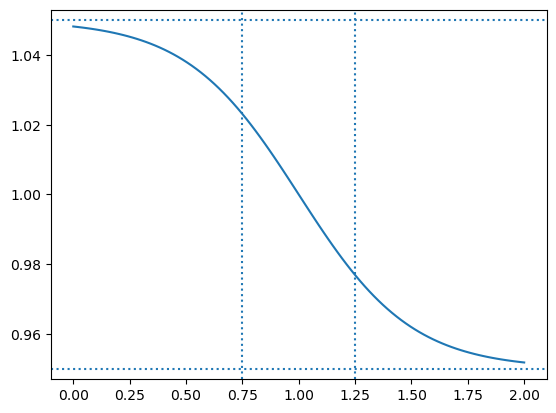

In [9]:
#| hide 
#| asap

x = linspace(0, 2, 100)
ampl = 0.05
wdth = 0.25
plt.plot(x, (1-2*ampl*(expit((x-1)/wdth)-0.5)))
plt.axvline(1-wdth, ls=':')
plt.axvline(1+wdth, ls=':')
plt.axhline(1+ampl, ls=':')
plt.axhline(1-ampl, ls=':');

#### Cubic Silica Carbide (3C-SiC)

In [10]:
#| exporti

def select_asap_model(comp='SiC'):
    '''
    This simple function selects the latest *working* OpenKIM model
    containing `comp` in the name. Required since some models are 
    not loding properly and the names are not stable.
    OUTPUT
    ------
    Name of the model. If nothing is found returns None.
    '''
    import asap3
    models = []
    for pot in [pot for pot in asap3.OpenKIMavailable() if comp in pot]:
        try :
            calc = asap3.OpenKIMcalculator(pot)
            models.append(pot)
        except asap3.AsapError :
            pass
    if models :
        model = sorted(models, key=lambda m: m.split('_')[3])[-1]
    else :
        model = None
    return model

In [11]:
#| asap

from ase.build import bulk
from ase.spacegroup import crystal
import asap3
from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat

# Local copy of model from OpenKIM-models from 2019
# model = 'data/Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# Model form 2019 OpenKIM-models package
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# Model form 2021 OpenKIM-models package
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_004'
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005SiII_SiC__MO_408791041969_003'
# model = 'MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000'

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'
sc = [int(v) for v in sys_size.split('x')]
SiC = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
SiC.set_calculator(asap3.OpenKIMcalculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


### The calculator option in sampler

The sampler needs to create a new `Atoms` object for distorted structures and needs a new calculator for this object. Most calculators support re-usage of the calculator object so you can pass just a calculator created for this purpose. Other, notably `asap3.OpenKIMcalculator`, modify the calculator object in-place and make it non-reusable. For such cases you need to pass a generator function in this argument which creates a fresh calculator on each call. The simplest variant is to just use lambda to create the anonymous generator (see example below).

In [12]:
#| asap

T = 600
xsl = []
dofmu = []
xi=1
chi=0.66
chi=1

sampler = HECSS(SiC, lambda : asap3.OpenKIMcalculator(model), 
                delta_sample=0.01, width=1,
                xi=xi, chi=chi, pbar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

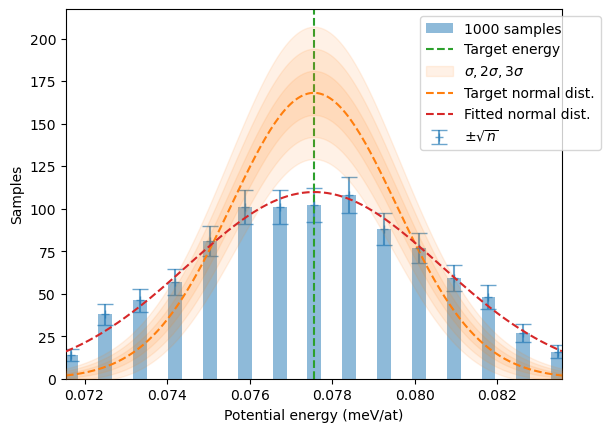

In [13]:
#| asap

N = 1_000
samples = [s for s in tqdm(sampler.sample(T, N, 
                                          dofmu_list=dofmu, 
                                          xscale_list=xsl), total=N)]
plot_stats(samples, T, sqrN=True)  

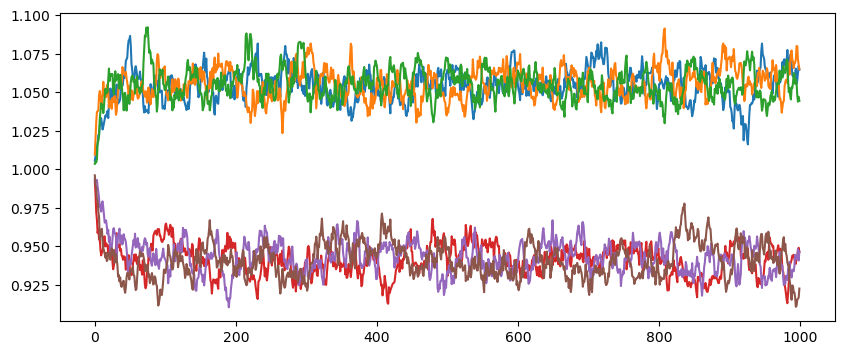

In [14]:
#| asap

plt.figure(figsize=(10,4))
for n, el in enumerate(set(SiC.get_chemical_symbols())):
    elmap = np.array(SiC.get_chemical_symbols()) == el
    plt.plot(np.array(xsl)[:,elmap,:].mean(-2), label=el)
# plt.legend()

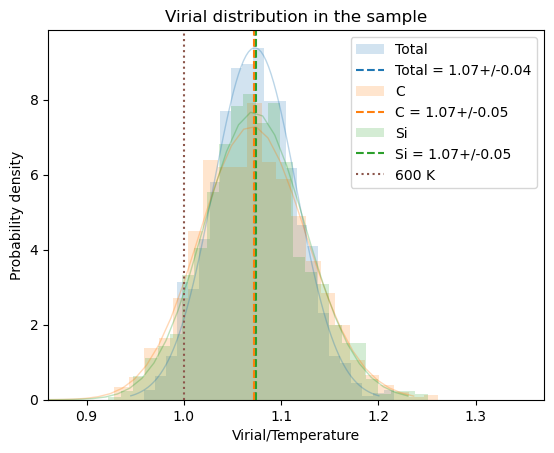

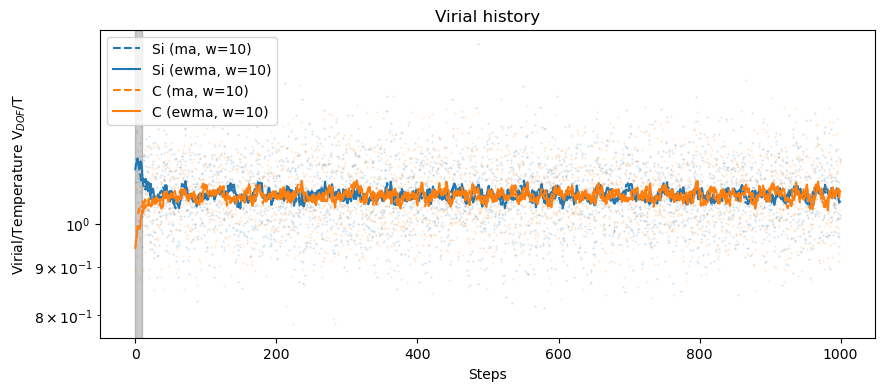

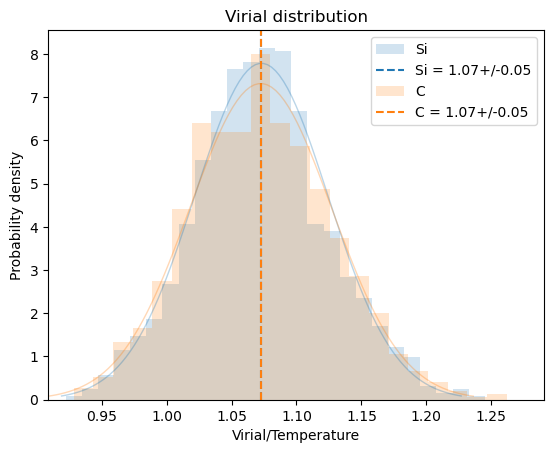

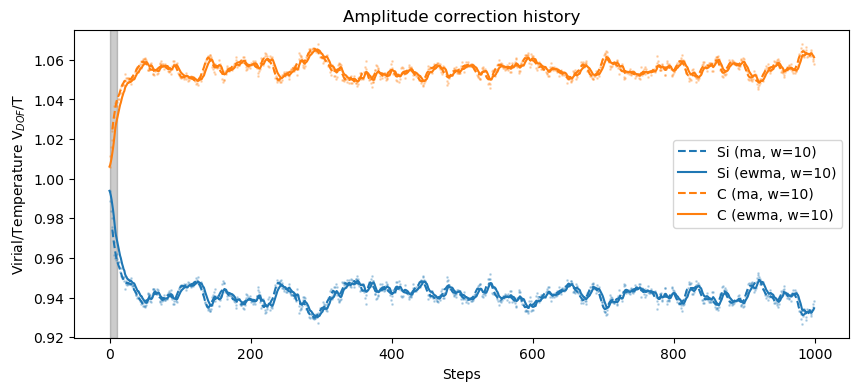

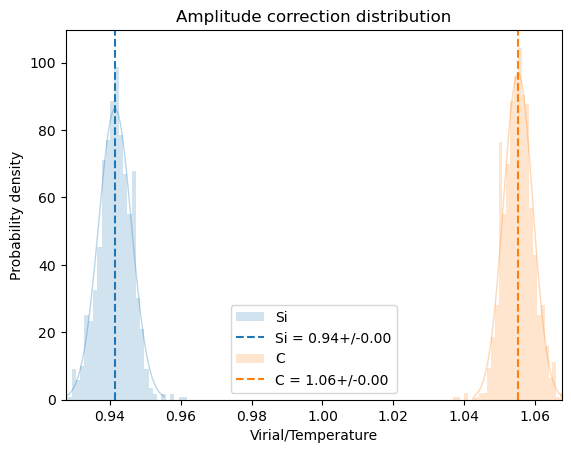

In [15]:
#| hide
#| asap
plot_virial_stat(SiC, samples, T)
plot_dofmu_stat(SiC, dofmu)
plot_xs_stat(SiC, xsl)

In [16]:
#| hide
#| asap

m = np.mean([_[-1] for _ in samples])
s = np.std([_[-1] for _ in samples])

s_target = np.sqrt(3/2)*un.kB*T/np.sqrt(len(SiC))

# We should get N samples
assert len(samples) == N

# The mean really should be inside target 2*sigma around T
assert np.abs(m - 3*T*un.kB/2) < 2*s_target

# And sigmas should be within 20% of each other
# assert np.abs(s/s_target - 1)<0.2

#### Olivine in the cubic spinel structure (gamma phase)

In [17]:
#| asap 

omodel = select_asap_model('Universal')
print(f'Using potential model: {omodel}')

oliv = ase.io.read('data/spinel.POSCAR')
oliv.set_calculator(asap3.OpenKIMcalculator(omodel))
print(f'Space group: {spglib.get_spacegroup(oliv)}')

Using potential model: LJ_ElliottAkerson_2015_Universal__MO_959249795837_003
Space group: Fd-3m (227)


In [18]:
#| asap 

print(f'Max. stress: {np.abs(oliv.get_stress()[:3]).max()/un.GPa:.3f} GPa')
print(f'Max. force : {np.abs(oliv.get_forces()).max():.3f} eV/A')

Max. stress: 0.881 GPa
Max. force : 0.002 eV/A


  0%|          | 0/500 [00:00<?, ?it/s]

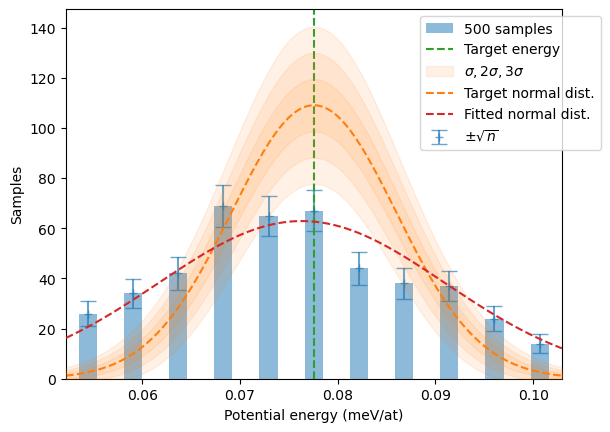

In [19]:
#| asap 

T = 600
dofmu = []
xsl = []
xi = 1
chi = 1
osampler = HECSS(oliv, lambda : asap3.OpenKIMcalculator(omodel), 
                 delta_sample=0.01, width=0.7,
                 xi=xi, chi=chi,
                 )
N = 5_00
osamples = [s for s in tqdm(osampler.sample(T, N, 
                                            dofmu_list=dofmu, xscale_list=xsl), total=N)]
plot_stats(osamples, T, sqrN=True)

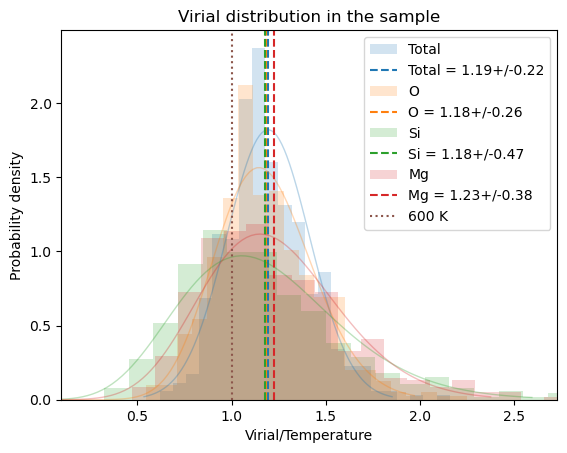

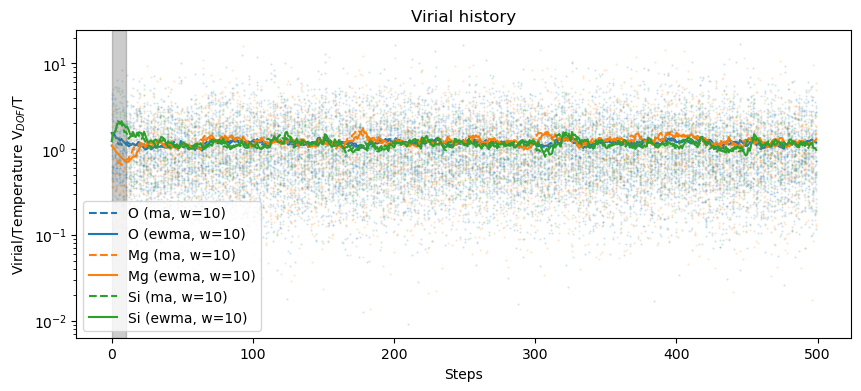

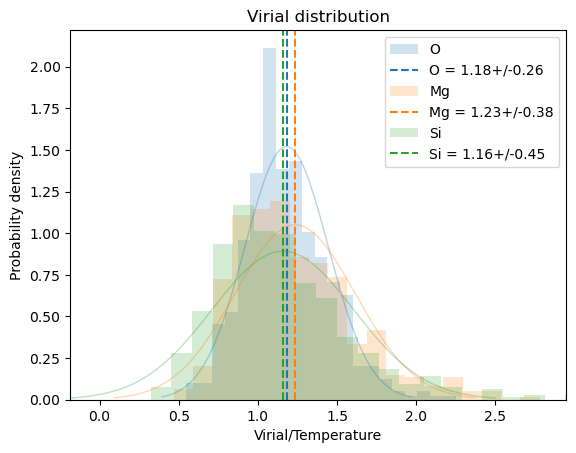

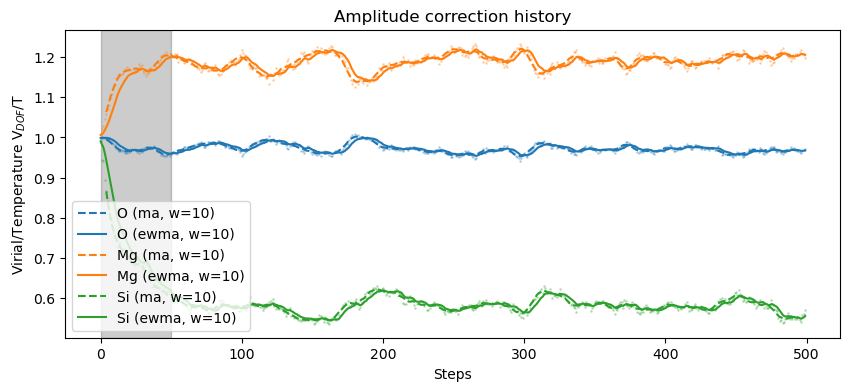

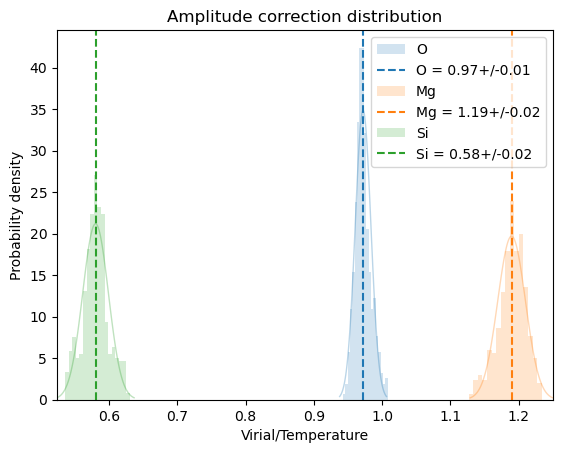

In [20]:
#| hide
#| asap
    
plot_virial_stat(oliv, osamples, T)
plot_dofmu_stat(oliv, dofmu, skip=10, window=10)
plot_xs_stat(oliv, xsl, skip=50, window=10)

In [21]:
#| hide
#| asap

m = np.mean([_[-1] for _ in osamples])
s = np.std([_[-1] for _ in osamples])

s_target = np.sqrt(3/2)*un.kB*T/np.sqrt(len(oliv))

# We should get N samples
assert len(osamples) == N

# The mean really should be inside target 2*sigma around T
assert np.abs(m - 3*T*un.kB/2) < 2*s_target

# And sigmas should be within 20% of each other
# assert np.abs(s/s_target - 1)<0.2

#### Continuation of the earlier calculation

In [22]:
#| hide
#| asap

N = 500
osampler2 = HECSS(oliv, lambda : asap3.OpenKIMcalculator(omodel), 
                  delta_sample=0.01, width=0.7, xi=xi, chi=chi)

osamples += [s for s in tqdm(osampler2.sample(T, N, 
                                              xscale_init=calc_init_xscale(oliv, xsl),
                                              dofmu_list=dofmu, 
                                              xscale_list=xsl), total=N)]

  0%|          | 0/500 [00:00<?, ?it/s]

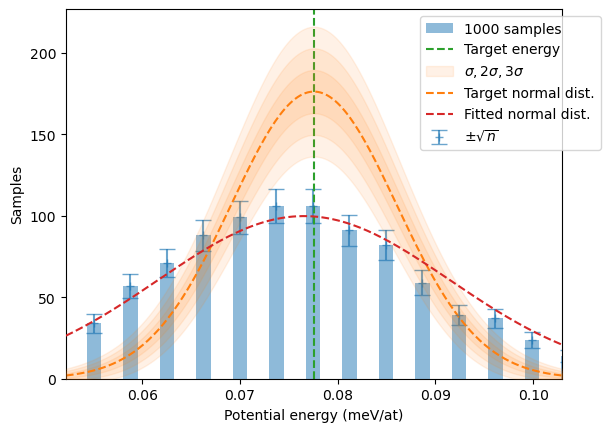

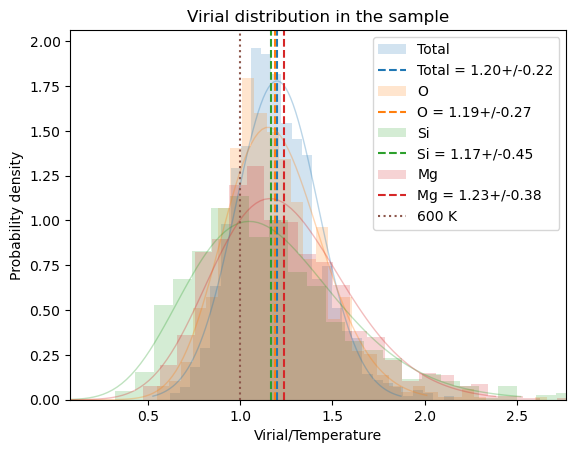

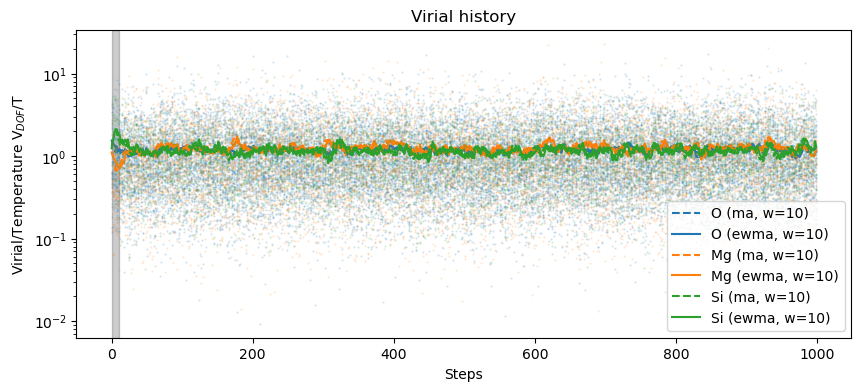

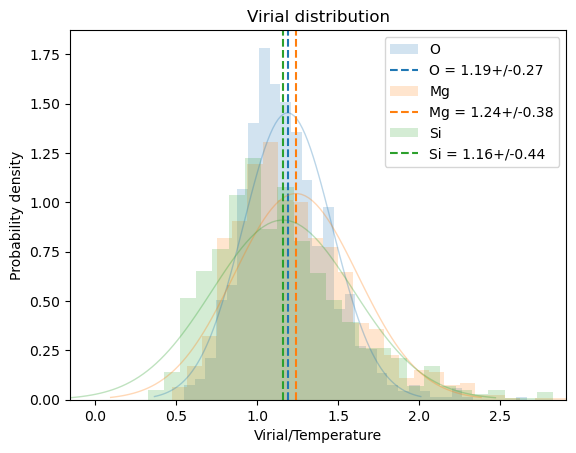

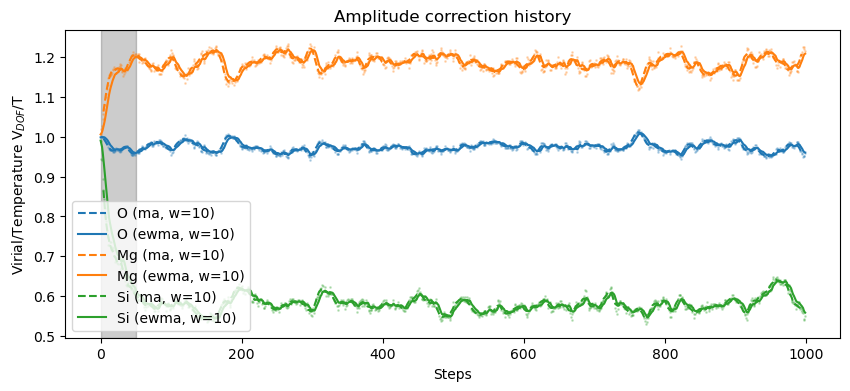

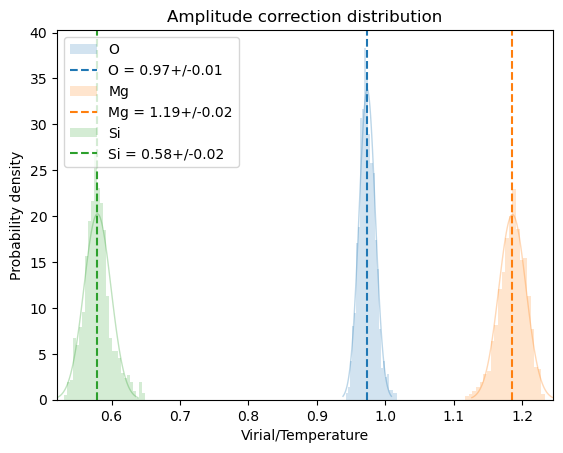

In [23]:
#| hide
#| asap

plot_stats(osamples, T, sqrN=True)
plot_virial_stat(oliv, osamples, T)
plot_dofmu_stat(oliv, dofmu)
plot_xs_stat(oliv, xsl, skip=50)

In [24]:
#| hide
#| asap

T = 300
N = 100
sampler = HECSS(SiC, lambda : asap3.OpenKIMcalculator(model), T)

In [25]:
# #| hide
# #| asap

# smpl = sampler.generate()
# smpl += sampler.generate()
# smpl += sampler.generate(20)
# assert len(smpl) == (2*N+20)

In [26]:
#| export
def normalize_conf(c, base):
    '''
    Normalize the configuration `c` relative to the basic structure `base`.
    Normalization is performed by "nuwrapping" the displacements of atoms
    when they cross the periodic boundary conditions in such a way that the
    atoms are not "jumping" from one side of the cell to the other. 
    
    E.g. if the atom at r=(0,0,0) goes to the relative position (-0.01, 0, 0)
    it is "wrapped" by PBC to the r=(0.99, 0, 0). Thus if we naiively calculate
    the displacement we will get a large positive displacement (0.99 of the cell 
    vector) instead of a small negative one. 
    
    This function reverses that process making the positions suitable for 
    differentiation. The positions may be part of a continous trajectory or
    just independent configurations. This makes it impossible for described 
    procedure to work if the displacements are above 1/2 of the unit cell.
    For sefety this implementation is limited to displacements < 1/3 of the 
    unit cell. If any coordinate changes by more then 1/3 the function
    will rise an AssertionError exception.
    
    This implementation is not suitable for tracking positions in the system
    with systematic drift (e.g. long MD trajectory with non-perfect momentum
    conservation). For stronger implementation suitable for such cases look
    at dxutils package.
    '''
    cell = base.get_cell()
    spos = c.get_scaled_positions()
    bspos = base.get_scaled_positions()

    # Unwrap the displacement relative to base
    sdx = spos - bspos
    sht = (sdx < -0.5)*1 - (sdx > 0.5)*1
    sdx += sht

    # Check if fractional displacements are below 1/3
    assert (abs(sdx) < 1/3).all()

    # Calculate unwrapped spos
    spos = bspos + sdx

    # Return carthesian positions, fractional positions
    return dot(spos,cell), spos

In [27]:
#| hide
from ase.build import bulk
from numpy import allclose

# Use structure with most of the atoms 
# on the surface of the unit cell: rocksalt
b = bulk('NaCl', 'rocksalt', a=3.6, cubic=True).repeat((3,3,3))
c = bulk('NaCl', 'rocksalt', a=3.6, cubic=True).repeat((3,3,3))

# Displace the atoms
c.rattle(stdev=0.5, seed=42)

# Store unwrapped positions
unwrapped = c.get_scaled_positions(wrap=False)

# Wrap the positions
c.set_scaled_positions(c.get_scaled_positions(wrap=True))

# Check if the reversal worked
assert allclose(unwrapped, normalize_conf(c,b)[1])